**Копирование и скачивание датасета BCCD**

In [ ]:
%%shell

git clone https://github.com/Shenggan/BCCD_Dataset.git
cd BCCD_Dataset

cp export.py ../
cp plot.py ../

Cloning into 'BCCD_Dataset'...
remote: Enumerating objects: 800, done.
remote: Total 800 (delta 0), reused 0 (delta 0), pack-reused 800 (from 1)
Receiving objects: 100% (800/800), 7.39 MiB | 38.20 MiB/s, done.
Resolving deltas: 100% (378/378), done.


Для корректной работы в скачанном export.py нужно поменять путь к папке, в которой хранятся аннотации на
BCCD_Dataset/BCCD/Annotations/*.xml

In [ ]:
#выполнить файл для формирования test.csv с данными картинок датасета
#этим файлом надо заменить файл, который идет с датасетом
#можно сразу загрузить ранее сформированный файл test.csv, тогда эту строку не запускать
!python /content/export.py

In [ ]:
import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image, ImageDraw
import pandas as pd
import torchvision as tv

import time
from torchvision.models.detection import ssd300_vgg16
import matplotlib.pyplot as plt


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu' #колаб не всегда позволят подключиться к cuda
device

'cuda'

In [ ]:
class BCCD(torch.utils.data.Dataset):
  """класс формирования датасета BCCD
  """
  def __init__(self, root = '/content/', trans = None):
    """trans - преобразования, которые можно потом делать с train данными
    root - путь для колаб
    """
    self.root = root

    self.data = pd.read_csv(os.path.join(root, 'test.csv')) #считываем данные из файла в датафрейм пандас

    #записываю в атрибут imgs пути к картинкам, unique чтобы точно не было дублей
    self.imgs = self.data['filename'].unique()
    #обязательные преобразования входных картинок для приведения к требованиям сети
    #модель принимает на вход картинку 300х300 со значениями от 0 до 1.
    #но эти преобразования она входящего изображения она делает внутри себя, поэтому здесь они закомментированы
    self.transforms = tv.transforms.Compose([
        #tv.transforms.Resize([300,300]),
        tv.transforms.ToTensor(),
        #tv.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    #выбираю уникальные классы из столбца cell_type + класс фона
    self.classes = ['background'] + list(self.data['cell_type'].unique())
    #записываю словарь соответствия классов и номеров классов в атрибут
    self.classes_idx = {c : i for i, c in enumerate(self.classes)}

  def get_image(self, idx):
    """метод получения изображения по индексу
    """
    filename = self.imgs[idx]
    img = Image.open(os.path.join(self.root+'BCCD_Dataset/BCCD/JPEGImages',filename)).convert("RGB")
    return img


  def __getitem__(self, idx):
    """магческий метод для возможности обращения к объекту класса как к итерируемому множеству - по индексу
    """
    filename = self.imgs[idx]

    #открываем изображение как изображение из файла по пути, для дальнейшей обработки
    img = Image.open(os.path.join(self.root+'BCCD_Dataset/BCCD/JPEGImages',filename)).convert("RGB")

    x = self.data
    x = x[x['filename'] == filename ] #выбираем нужный файл (в нем несколько объектов)
    x = x[x.xmin < x.xmax] #проверяем чтобы xmin < xmax и ymin < ymax
    x = x[x.ymin < x.ymax] #есть 2 записи, в которых они равны, т.е. рамка - точка
    x = np.array(x)

    for i in range (len(x)): #для каждого объекта в файле
      x[i,1] = self.classes_idx[x[i,1]] #присваиваем номер класса вместо названия

    #выбираем все метки классов (1-й индекс (0-й - пути к файлам))
    labels = torch.as_tensor(x[:,1].astype(int), dtype = torch.int64).to(device)
    #выбираем координаты углов
    boxes = torch.as_tensor(x[:, [2,4,3,5]].astype(float), dtype = torch.float32).to(device)

    image_id = torch.tensor([idx])
    area = (boxes[:,2] - boxes[:,0]) * (boxes[:,3] - boxes[:, 1])  #0-xmin, 1-ymin, 2-xmax, 3-ymax

    iscrowd = torch.zeros((len(x),), dtype=torch.int64)

    img = self.transforms(img).to(device) #применяем обязательные преобразования к изображению

    return img, {'boxes': boxes, 'labels': labels}

  def __len__(self):
      return len(self.imgs) #возвращает общее число файлов(картинок)

In [ ]:
BCCD_data = BCCD() #создаем объект класса

In [ ]:
BCCD_data.classes_idx #посмотреть как работает

{'background': 0, 'RBC': 1, 'Platelets': 2, 'WBC': 3}

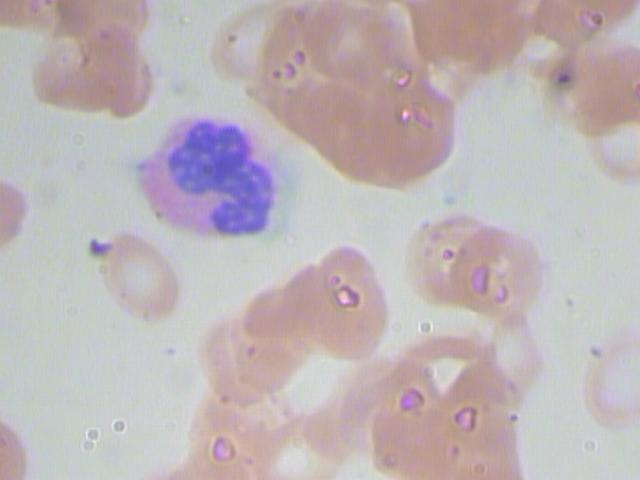

In [ ]:
BCCD_data.get_image(9)

In [ ]:
BCCD_data[9]

(tensor([[[0.6471, 0.6471, 0.6510,  ..., 0.7020, 0.7098, 0.7176],
          [0.6471, 0.6471, 0.6510,  ..., 0.7020, 0.7137, 0.7255],
          [0.6471, 0.6510, 0.6510,  ..., 0.7098, 0.7255, 0.7255],
          ...,
          [0.7137, 0.7098, 0.7059,  ..., 0.7882, 0.7882, 0.7882],
          [0.7176, 0.7098, 0.7020,  ..., 0.7882, 0.7882, 0.7882],
          [0.7176, 0.7098, 0.7020,  ..., 0.7882, 0.7882, 0.7882]],
 
         [[0.5294, 0.5294, 0.5333,  ..., 0.6118, 0.6235, 0.6314],
          [0.5294, 0.5294, 0.5333,  ..., 0.6196, 0.6275, 0.6392],
          [0.5294, 0.5333, 0.5333,  ..., 0.6275, 0.6392, 0.6510],
          ...,
          [0.5961, 0.5922, 0.5882,  ..., 0.8078, 0.8078, 0.8078],
          [0.6000, 0.5922, 0.5843,  ..., 0.8078, 0.8039, 0.8039],
          [0.6000, 0.5922, 0.5843,  ..., 0.8078, 0.8039, 0.8039]],
 
         [[0.5373, 0.5373, 0.5412,  ..., 0.6824, 0.7059, 0.7137],
          [0.5373, 0.5373, 0.5412,  ..., 0.6863, 0.7098, 0.7216],
          [0.5373, 0.5412, 0.5412,  ...,

**Задание модели**

In [ ]:
model = ssd300_vgg16(pretrained = True).to(device)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SSD300_VGG16_Weights.COCO_V1`. You can also use `weights=SSD300_VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/ssd300_vgg16_coco-b556d3b4.pth" to /root/.cache/torch/hub/checkpoints/ssd300_vgg16_coco-b556d3b4.pth


100%|██████████| 136M/136M [00:00<00:00, 179MB/s]


**Обучение**

In [ ]:
len(BCCD_data) #всего картинок

364

In [ ]:
len_test=5 #приму длину тестовой выборки - 5 чтобы потом проще было отрисовывать результат предсказания модели

In [ ]:
torch.manual_seed(42)
index = torch.randperm(len(BCCD_data)).tolist() #в случайном порядке переставляем индексы в пределах от 0 до всего кол-ва картинок

trn = list(index[:-len_test]) #список индексов train, все, кроме 5 последних элементов
tst = list(index[-len_test:]) #список индексов test, 5 последних элемента

In [ ]:
epochs = 50 #количество эпох

In [ ]:
batch_size = 50 #размер батча

In [ ]:
model.train() #переходим в режим обучения модели

trainer = torch.optim.Adam(model.parameters(), lr = 0.0001) #задаем оптимизатор и шаг обучения
start = time.time() #фиксирем время начала обучения

for ep in range(epochs): #счетчик эпох
  perm = np.random.permutation(trn) #в случайном порядке перемешиваем train датасет в каждой эпохе
  i = 0 #счетчик количества обработанных картинок
  #инициализируем начальное (нулевое) состояние функции потерь
  l0 = 0
  l1 = 0
  l2 = 0
  ln = 0  #заводим счетчик обработанных батчей

  while True:
    features = []
    targets = []
    trainer.zero_grad() #обнуляем градиенты чтобы не приплюсовать что-нибудь лишнее
    for j in range(batch_size): #из всех объектов в батче формируем наор картинок и целевых переменных (рамки, классы)
        if i >= len(perm):
          break
        p, t = BCCD_data[perm[i]]
        features.append(p) #изображение
        targets.append(t) #рамки и класс
        i+=1
    pred = model(features, targets) #передаем выбранные наборы в модель, получаем предсказанные значения
    loss = pred['bbox_regression'] * pred['bbox_regression'] * 20 + pred['classification']
    loss.backward() #просчитываем грандиенты
    trainer.step() #делаем шаг оптимизатора
    #считаем ф-цю потерь регрессии (предсказание координат рамок)
    l1 += pred['bbox_regression'].item()
    # считаем ф-цию потерь классификации
    l2 += pred['classification'].item()
    # считаем суммарную функцию потерь
    l0 += loss.item()
    ln+=1 # увеличиваем счетчик кол-ва обработанных батчей

    if i >= len(perm):
      break

  print(f'time - {round((time.time() - start)/60000,5)}мин, epoch - {ep}, l0/ln - {round(l0/ln,4)}, l1/ln - {round(l1/ln,4)},l2/ln - {round(l2/ln,4)}')
  start = time.time()



time - 0.00024мин, epoch - 0, l0/ln - 6.5249, l1/ln - 0.3996,l2/ln - 2.4634
time - 0.00025мин, epoch - 1, l0/ln - 3.2642, l1/ln - 0.3,l2/ln - 1.4407
time - 0.00024мин, epoch - 2, l0/ln - 2.3981, l1/ln - 0.2316,l2/ln - 1.3186
time - 0.00024мин, epoch - 3, l0/ln - 1.772, l1/ln - 0.1753,l2/ln - 1.1535
time - 0.00024мин, epoch - 4, l0/ln - 1.4542, l1/ln - 0.1445,l2/ln - 1.0345
time - 0.00024мин, epoch - 5, l0/ln - 1.2613, l1/ln - 0.1245,l2/ln - 0.9497
time - 0.00024мин, epoch - 6, l0/ln - 1.098, l1/ln - 0.1076,l2/ln - 0.8653
time - 0.00024мин, epoch - 7, l0/ln - 0.9562, l1/ln - 0.0947,l2/ln - 0.7765
time - 0.00024мин, epoch - 8, l0/ln - 0.8582, l1/ln - 0.0857,l2/ln - 0.7104
time - 0.00024мин, epoch - 9, l0/ln - 0.7797, l1/ln - 0.0793,l2/ln - 0.6532
time - 0.00024мин, epoch - 10, l0/ln - 0.7603, l1/ln - 0.0779,l2/ln - 0.6385
time - 0.00024мин, epoch - 11, l0/ln - 0.6808, l1/ln - 0.0699,l2/ln - 0.5821
time - 0.00024мин, epoch - 12, l0/ln - 0.631, l1/ln - 0.0679,l2/ln - 0.5386
time - 0.00024м

Использованные опитизаторы:   
epoch - 19, l0/ln - 1.0175, l1/ln - 0.0902,l2/ln - 0.8546 - Адам   20 эпох   
epoch - 19, l0/ln - 3.6808, l1/ln - 0.3233,l2/ln - 1.5824 Adamax   20 эпох   
epoch - 19, l0/ln - 3.4806, l1/ln - 0.3089,l2/ln - 1.5695   SGD    20 эпох  
epoch - 49, l0/ln - 0.0873, l1/ln - 0.0242,l2/ln - 0.0754 Адам 50 эпох - итоговое предсказание ниже на этой модели

In [ ]:
BCCD_data[176][1]['boxes'][1]

tensor([460.,  90., 566., 195.], device='cuda:0')

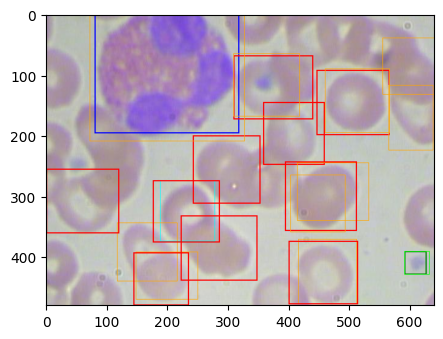

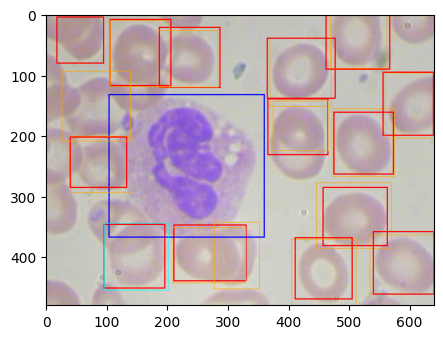

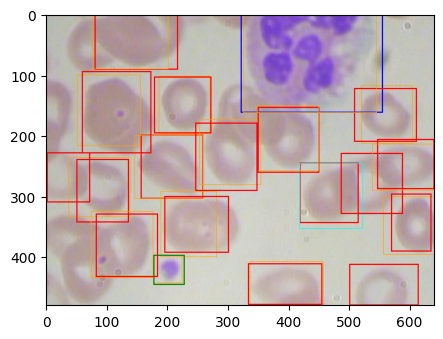

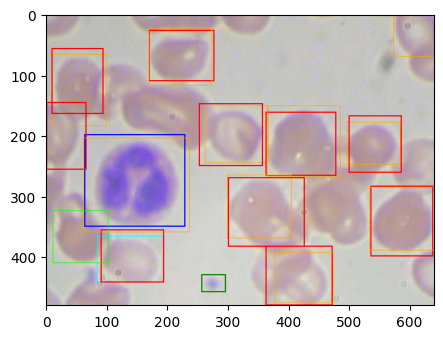

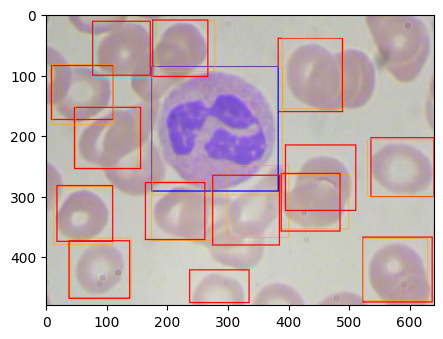

In [ ]:
model.eval()
#tst = list(range(len(BCCD_test)))
for i in tst:
  p,t = BCCD_data[i]
  outputs = model([p])
  img = BCCD_data.get_image(i)
  draw = ImageDraw.Draw(img)
  classes = outputs[0]['labels'].cpu().numpy()
  scores = outputs[0]['scores'].detach().cpu().numpy()
  boxes = outputs[0]['boxes'].detach().cpu().numpy()
  for j,box in enumerate(boxes):
    if scores[j] > 0.5 :
      c = classes[j]
      c = c if c < 4 else 0
      #{'background': 0, 'RBC'(эритроциты): 1, 'Platelets (тромбоциты)': 2, 'WBC' (лейкоциты): 3}
      cl =     ['black', 'red',    'green','blue'] #названия цветов для предсказанных рамок
      clmark = ['black', 'orange', 'lime', 'cyan'] #названия цветов для размеченных рамок
      draw.rectangle(xy=box.tolist(), outline=cl[c], width = 2) #рисуем предсказанные рамки
      if j< len(BCCD_data[i][1]['boxes']): #предсказанных рамок может быть больше чем размеченных
        draw.rectangle(xy = BCCD_data[i][1]['boxes'][j].tolist(), outline = clmark[c]) #рисуем размеченные рамки
  plt.figure(figsize=(5, 5))
  plt.imshow(img)

#Вывод
Модель хорошо классифиирует эритроциты (красный жирный - размеченные, оранжевые - предсказанные рамки) и тромбоциты (зеленый жирный размеченные, салатовые - предсказанные рамки).
Но не очень хорошо определяет класс лейкоцито (должны быть синие жирные размеченные и голубые предсказанные рамки), а предсказывает почти везде оранжевый класс - как эритроциты, но расположение самих рамок близко к размеченным.